In [1]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd

from slope_area.builder import (
    BuilderConfig,
    OutletPlotBuilder,
    ResolutionPlotBuilder,
    Trial,
    TrialConfig,
    TrialResults,
    Trials,
)
from slope_area.features import Outlet, Outlets
from slope_area.geomorphometry import HydrologicAnalysisConfig
from slope_area.logger import create_logger
from slope_area.paths import PROJ_ROOT
from slope_area.plot import SlopeAreaPlotConfig, slope_area_plot

logger = create_logger(__name__)

16:11:37 DEBUG slopeArea.slope_area.config          is_notebook(): Code is running in notebook


# Paths

In [2]:
dem = PROJ_ROOT / 'data' / 'raw' / 'copdem_30m.tif'
outlets = PROJ_ROOT / 'data' / 'raw' / 'copdem_30m_outlets.shp'

out_dir = PROJ_ROOT / 'data' / 'processed' / '01_plot_from_outlets'
out_dir_sequential = out_dir / 'sequential'
out_dir_parallel = out_dir / 'parallel'
out_dir_outlet_builder = out_dir / 'outlet_builder'
out_dir_resolution_builder = out_dir / 'resolution_builder'

out_fig_sequential = out_dir_sequential / 'slope_area.png'
out_fig_outlet_builder = out_dir_outlet_builder / 'slope_area.png'
out_fig_resolution_builder = out_dir_resolution_builder / 'slope_area.png'

assert dem.exists()
assert outlets.exists()

# Configs

In [3]:
max_workers = 3
resolutions = [(res, res) for res in range(30, 60, 5)]
hydrologic_analysis_config = HydrologicAnalysisConfig(
    streams_flow_accumulation_threshold=1000, outlet_snap_distance=100
)

plot_config = SlopeAreaPlotConfig(
    hue='slope_type',
    col='trial',
    log_interval=0.25,
    min_gradient=0.01,
    col_wrap=-1,
    height=5,
    aspect=1,
    title=None,
    xlabel='Drainage area (m$^2$)',
    ylabel='Slope (m/m)',
    label_font_size=16,
    title_font_size=10,
    legend_font_size=10,
    tick_font_size=14,
    add_vlines=False,
    kind='line',
    show=False,
)

# Read outlets

In [4]:
logger.info('Reading outlets at %s' % outlets)
gdf = gpd.read_file(outlets).sort_values(by='name')
outlets = Outlets.from_gdf(gdf, name_field='name')

16:11:38 INFO slopeArea.__main__             <module>(): Reading outlets at /media/alex/alex/python-modules-packages-utils/slope-area/data/raw/copdem_30m_outlets.shp


# Run trials sequentially

In [5]:
def trial_from_outlet(outlet: Outlet, out_dir: Path) -> Trial:
    assert outlet.name is not None
    config = TrialConfig(
        name=outlet.name,
        outlet=outlet,
        hydrologic_analysis_config=hydrologic_analysis_config,
        dem=dem,
        out_dir=out_dir / outlet.name,
        resolution=None,
    )
    return Trial(config=config)


trials = Trials(
    [trial_from_outlet(outlet, out_dir_sequential) for outlet in outlets]
)
results = TrialResults()
for trial in trials:
    results.append(trial.run())

16:11:38 INFO slopeArea.slope_area.builder.Trial                  run(): Running...
16:11:38 INFO slopeArea.slope_area.builder.Trial          get_wbw_env(): Initialized Whitebox Environment
16:11:38 INFO slopeArea.slope_area.config          get_wbw_env(): Initialized Whitebox Environment
16:11:38 INFO slopeArea.slope_area.builder.Trial       preprocess_dem(): Breaching depressions in the DEM
16:11:38 INFO slopeArea.slope_area.builder.Trial             read_dem(): Reading DEM copdem_30m.tif
16:11:38 DEBUG slopeArea.slope_area.geomorphometry              wrapper(): HydrologicAnalysis.read_dem executed in 0.013222 seconds
16:11:38 INFO slopeArea.slope_area.builder.Trial       preprocess_dem(): Breaching single-cell pits
16:11:38 DEBUG slopeArea.slope_area.geomorphometry              wrapper(): HydrologicAnalysis.preprocess_dem executed in 0.058276 seconds
16:11:38 INFO slopeArea.slope_area.builder.Trial         compute_flow(): Computing the D8 pointer
16:11:38 INFO slopeArea.slope_area.bu

In [6]:
print('Slope types:', results[0].profiles['slope_type'].unique())
results[0].profiles.head()

Slope types: ['Slope 3x3' 'StreamSlopeContinuous']


,FID,VALUE,area,geometry,slope_type,slope,resolution
0,1,1.0,1485.877685,POINT (721210.846 548789.936),Slope 3x3,0.128512,None
1,2,1.0,3714.694335,POINT (721238.103 548762.679),Slope 3x3,0.042639,None
2,3,1.0,19316.410156,POINT (721319.874 548762.679),Slope 3x3,0.073741,None
3,4,1.0,23774.042968,POINT (721347.13 548762.679),Slope 3x3,0.089974,None
4,5,1.0,8915.266601,POINT (721265.36 548735.422),Slope 3x3,0.030129,None


16:12:29 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue='slope_type', col='trial', log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, legend_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend=True, show=False)
16:12:29 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
16:12:38 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/01_plot_from_outlets/sequential/slope_area.png


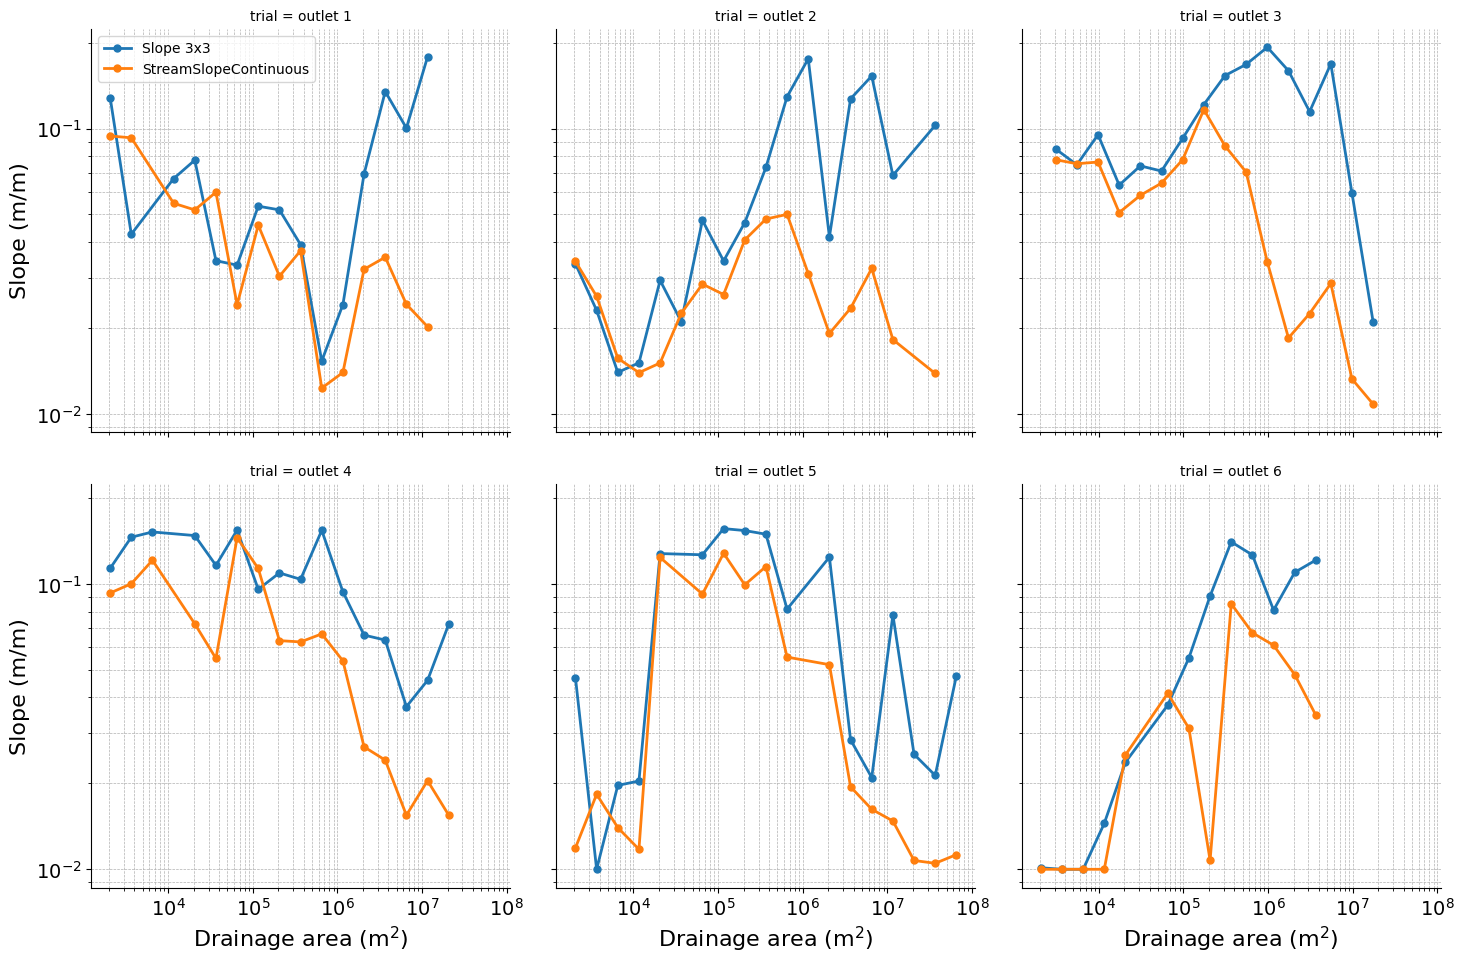

In [7]:
slope_area_plot(
    results.to_dataframe(), out_fig=out_fig_sequential, config=plot_config
)

# Run trials in parallel

In [8]:
trials = Trials(
    [trial_from_outlet(outlet, out_dir_parallel) for outlet in outlets]
)
results = trials.run(max_workers=2)

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


16:13:22 INFO slopeArea.slope_area.builder.TrialsExecutor               gather(): Gathering results of TrialsExecutor


# Run trials with Builder objects

## OutletPlotBuilder - one plot for each outlet

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


16:13:57 INFO slopeArea.slope_area.builder.TrialsExecutor               gather(): Gathering results of TrialsExecutor
16:13:57 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue='slope_type', col='trial', log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, legend_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend=True, show=False)
16:13:57 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
16:14:05 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/01_plot_from_outlets/outlet_builder/slope_area.png


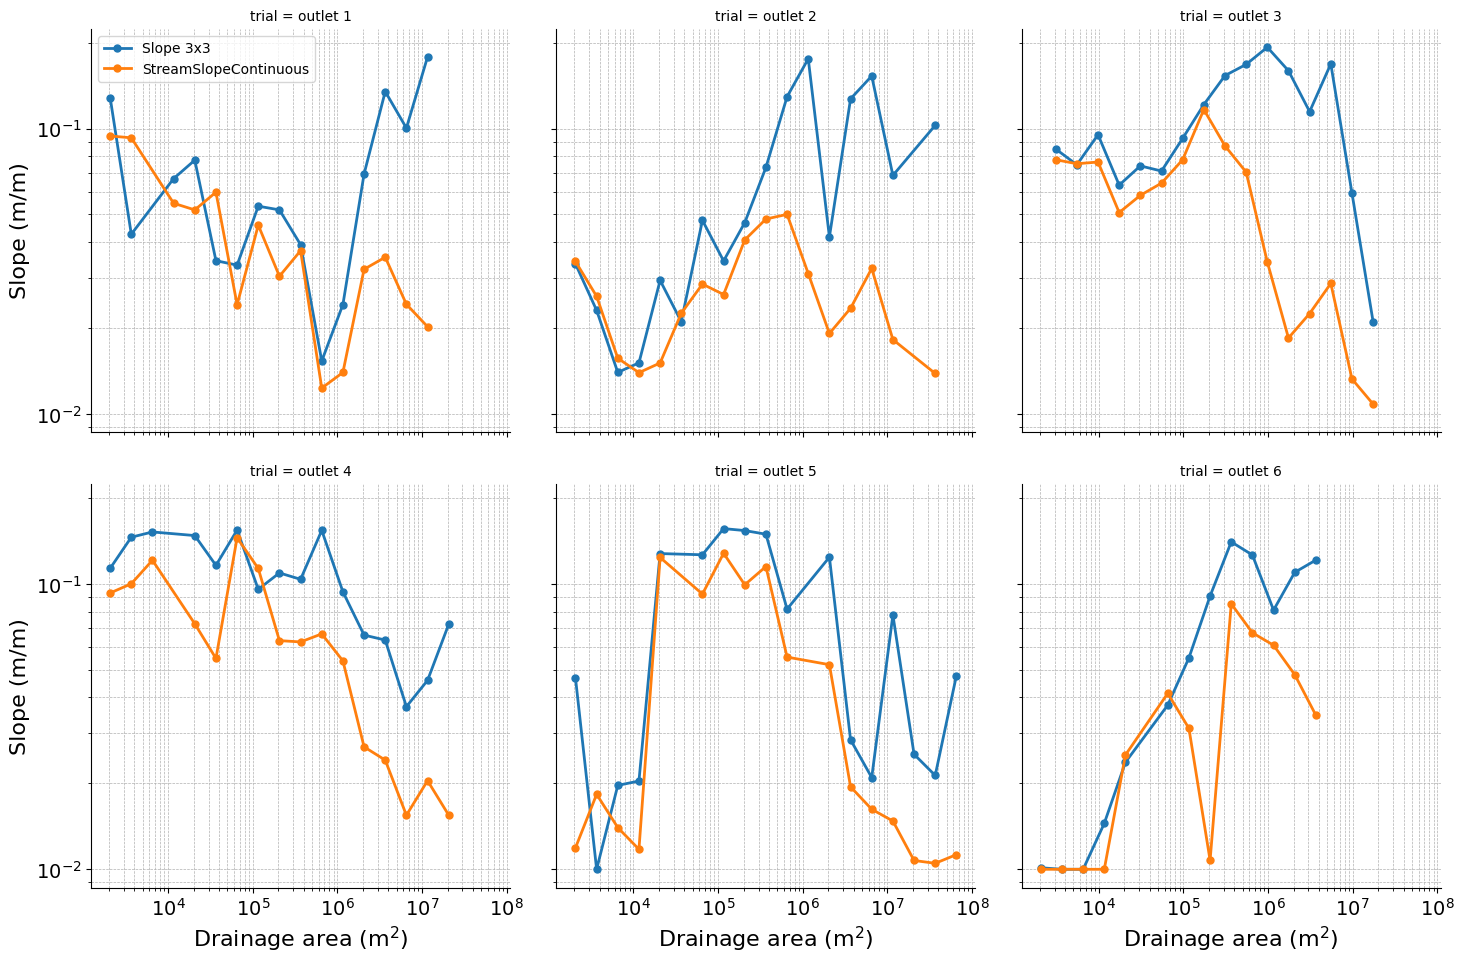

In [9]:
builder_config = BuilderConfig(
    hydrologic_analysis_config=hydrologic_analysis_config,
    out_dir=out_dir_outlet_builder,
    out_fig=out_fig_outlet_builder,
    plot_config=plot_config,
    max_workers=max_workers,
)
outlet_builder = OutletPlotBuilder(
    builder_config, dem=dem, outlets=outlets, resolution=None
)
results = outlet_builder.build()

## ResolutionPlotBuilder - multiple resolutions for one outlet

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


16:14:36 INFO slopeArea.slope_area.builder.TrialsExecutor               gather(): Gathering results of TrialsExecutor
16:14:36 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue='slope_type', col='trial', log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, legend_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend=True, show=False)
16:14:36 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
16:14:42 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/01_plot_from_outlets/resolution_builder/slope_area.png


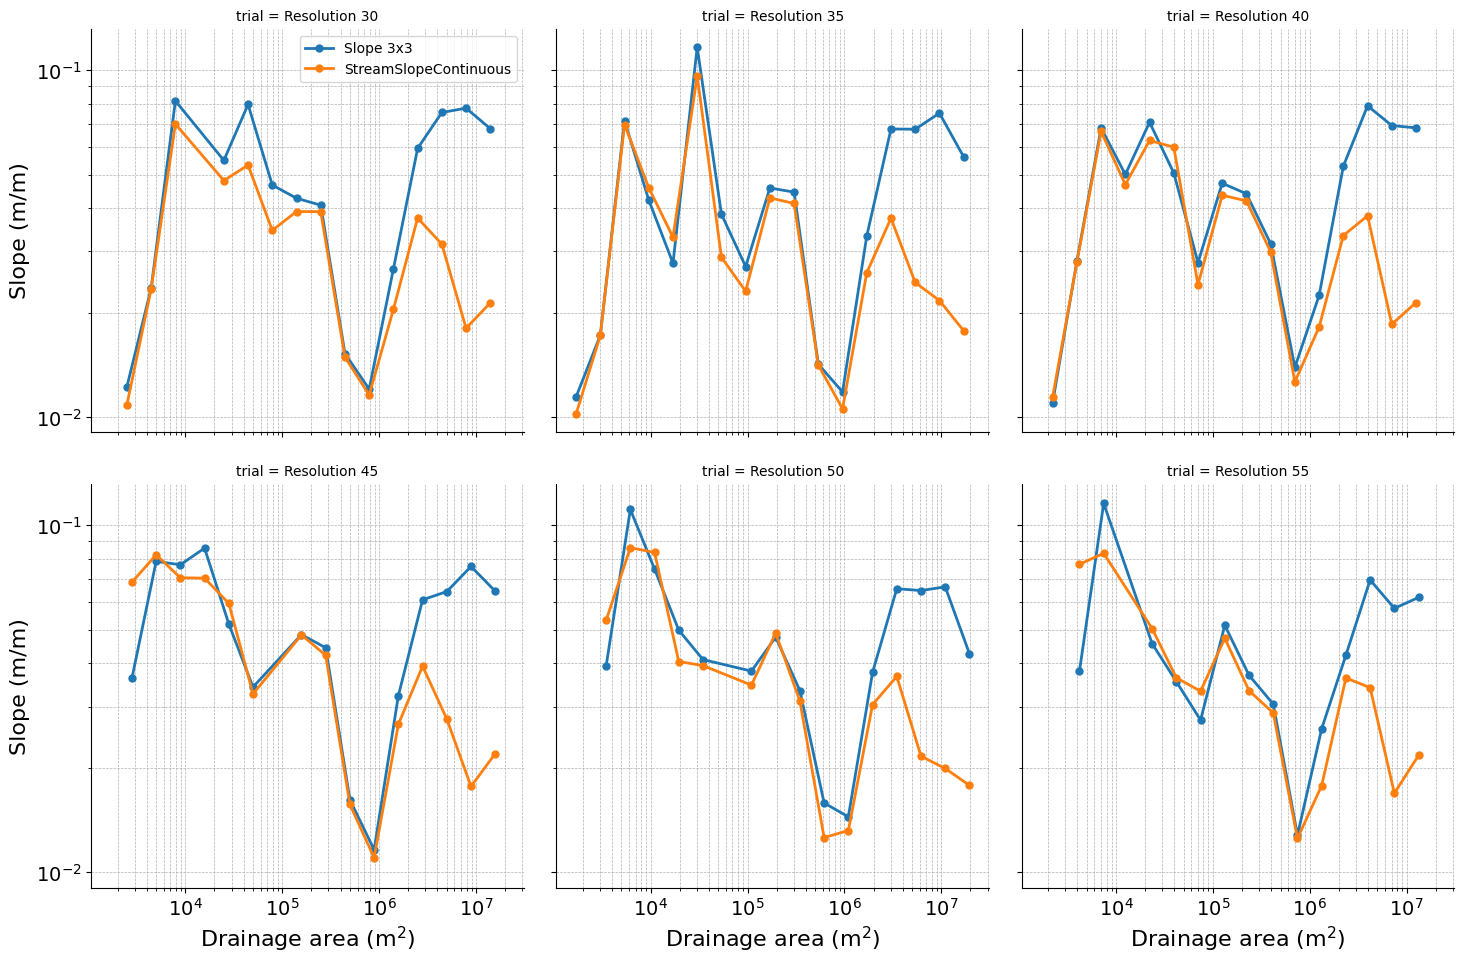

In [10]:
outlet = outlets[0]

builder_config = BuilderConfig(
    hydrologic_analysis_config=hydrologic_analysis_config,
    out_dir=out_dir_resolution_builder,
    out_fig=out_fig_resolution_builder,
    plot_config=plot_config,
    max_workers=max_workers,
)
outlet_builder = ResolutionPlotBuilder(
    builder_config, dem=dem, outlet=outlet, resolutions=resolutions
)
results = outlet_builder.build()